# scNym Cell Type Classification with Cell Atlas References

This notebook trains `scNym` cell type classification models using a relevant cell atlas dataset as training data and an unlabeled dataset from new experiment as target data.

We provide cell atlases for the mouse (Tabula Muris) and rat (Rat Aging Cell Atlas).

We demonstrate scNym by training on young rat cells and predicting on old cells.
Simply change the `UPLOAD_NEW_DATA` variable in the cells below to upload your own experiment instead.

## Install dependencies and import packages

In [1]:
!pip install tqdm ConfigArgParse numpy torch pandas scanpy matplotlib seaborn mock
!pip install scnym

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.3 MB 87 kB/s  eta 0:00:01
     |████████████████████████████████| 10.3 MB 52.1 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 59.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 58.2 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 82.7 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 81.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 72.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 61.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 51.0 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 50.8 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 68 kB 531 kB/s eta 0:00:011
     |████████████████████████████████| 58 kB 365 kB/s  eta 0:00:01
     |████████████████████████████████| 118 kB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 7.9 MB/s eta 0:00:01     |█████████████████████▌          | 1.6 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.6 MB 19.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 51.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 62.5 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 28 kB/s s eta 0:00:01     |█████████████████               | 13.8 MB 63.2 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 521 kB/s  eta 0:00:01
     |████████████████████████████████| 308 kB 66.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.1 MB 34.9 MB/s eta 0:00:01    |██████████████████▋      

     |████████████████████████████████| 48 kB 2.4 MB/s  eta 0:00:01
     |████████████████████████████████| 97 kB 1.9 MB/s  eta 0:00:01
     |████████████████████████████████| 147 kB 82.2 MB/s eta 0:00:01
     |███████████████████████████████▋| 153 kB 32.8 MB/s eta 0:00:01     |████████████████████████████████| 155 kB 32.8 MB/s 
     |████████████████████████████████| 77 kB 2.7 MB/s  eta 0:00:01
Using legacy 'setup.py install' for numpy-groupies, since package 'wheel' is not installed.
Using legacy 'setup.py install' for umap-learn, since package 'wheel' is not installed.
Using legacy 'setup.py install' for ConfigArgParse, since package 'wheel' is not installed.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: pandas
    Found existing installation

    Found existing installation: numpy-groupies 0+unknown
    Uninstalling numpy-groupies-0+unknown:
      Successfully uninstalled numpy-groupies-0+unknown
    Running setup.py install for numpy-groupies ... done
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
  Attempting uninstall: umap-learn
    Found existing installation: umap-learn 0.4.6
    Uninstalling umap-learn-0.4.6:
      Successfully uninstalled umap-learn-0.4.6
    Running setup.py install for umap-learn ... error
    ERROR: Command errored out with exit status 1:
     command: /usr/local/bin/python3.7 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-us09h7ah/umap-learn/setup.py'"'"'; __file__='"'"'/tmp/pip-install-us09h7ah/umap-learn/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
!pip install tensorflow

In [ ]:
# allow tensorboard outputs even though TF2 is installed
# broke the tensorboard/pytorch API
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import scnym
import torch

# file downloads
import urllib
import json
import os

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from scnym.api import scnym_api

## Get links to Cell Atlas datasets

In [ ]:
# download a hash table of addresses to pre-formatted cell atlas datasets
cell_atlas_json_url = 'https://storage.googleapis.com/calico-website-scnym-storage/link_tables/cell_atlas.json'
urllib.request.urlretrieve(
    cell_atlas_json_url,
    './cell_atlas.json'
)

with open('./cell_atlas.json', 'r') as f:
  CELL_ATLASES = json.load(f)

In [ ]:
print('Available Cell Atlases:')
for k in CELL_ATLASES.keys():
  print(k)

## Download a cell atlas to use as training data

In [ ]:
# change this variable to use a different atlas as your
# training data set
ATLAS2USE = 'rat'

if ATLAS2USE not in CELL_ATLASES.keys():
  msg = f'{ATLAS2USE} is not available in the cell atlas directory.'
  raise ValueError(msg)

In [ ]:
if not os.path.exists('train_data.h5ad'):
  urllib.request.urlretrieve(
      CELL_ATLASES[ATLAS2USE],
      'train_data.h5ad',
  )
else:
  print('`train_data.h5ad` is already present.')
  print('Do you really want to redownload it?')
  print('If so, run:')
  print('\t!rm ./train_data.h5ad')
  print('in a cell below.')
  print('Then, rerun this cell.')

In [ ]:
train_adata = anndata.read_h5ad('./train_data.h5ad',)
print('%d cells, %d genes in training data set.' % train_adata.shape)

218971 cells, 32884 genes in training data set.


/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [ ]:
# NOTE: Here we downsample the atlas to avoid memory issues
# with free Colab VMs
MAX_N_CELLS = 30000
if train_adata.shape[0] > MAX_N_CELLS:
  print('Downsampling training data to fit in memory.')
  print('Note: Remove this step if you have high RAM VMs through Colab Pro.')
  ridx = np.random.choice(train_adata.shape[0], size=MAX_N_CELLS, replace=False)
  train_adata = train_adata[ridx, :]

Downsampling training data to fit in memory.
Note: Remove this step if you have high RAM VMs through Colab Pro.


In [ ]:
# filter rare genes to save on memory
n_genes = train_adata.shape[1]
sc.pp.filter_genes(train_adata, min_cells=20)
n_genes -= train_adata.shape[1]
print(f'Removed {n_genes} genes.')
print('%d cells, %d genes in training data set.' % train_adata.shape)

Trying to set attribute `.var` of view, copying.


Removed 15500 genes.
30000 cells, 17384 genes in training data set.


In [ ]:
# save genes used in the model
np.savetxt('./model_genes.csv', train_adata.var_names, fmt='%s')

In [ ]:
# temporary
model_genes = np.loadtxt('./model_genes.csv', dtype='str')

## Import a new target data set

Here, we import a target data set that will be used as unlabeled data during training.
We transfer labels from the training data set (e.g. cell atlas) to the target data set in a final prediction step.

This tutorial uses a subset of the rat aging cell atlas as a target data set, but we provide code to upload your own target data set below.
We have found that uploading your data to Google Drive and then importing it to Colab tends to work best.
If you would like to upload your own data, we assume data is located in `/gdrive_root/scnym_data/target_data.h5ad`.
You can change this assumption in the code below to match the location of your data.

If you upload your own dataset, please format it into an `anndata.AnnData` object and normalize counts to `log(CPM + 1)` before using your data with `scNym`.
We also recommend that you filter out cells with low library sizes and genes with few measured cells using standard quality control practices (see [Ilicic et. al. 2016, *Genome Biology*](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0888-1) for details).
We have provided typical threshold values in the code below, but these should be adjusted to match the library size distribution and number of cells in your dataset.

An example of how to format your data is included below.

```python
adata = anndata.AnnData(
  X = X, # [Cells, Genes] scipy.sparse.csr_matrix or numpy.ndarray
  var = var, # [Genes, Features] pd.DataFrame with gene names as the index
  obs = obs, # [Cells, Features] pd.DataFrame with cell barcodes as the index
)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_genes(adata, min_cells=10)
```

In [ ]:
# change this variable to `True` if you would
# like to upload your own data
UPLOAD_NEW_DATA = False

In [ ]:
# this block uses old cells from the rat aging cell atlas
# as target data and uses only the young cells as training
# data.
# this code will not run if you are uploading your own data
# and changed the variable above.
if not UPLOAD_NEW_DATA:
  # set old cells as target data
  target_adata = train_adata[train_adata.obs['age']!='Y', :]
  # use only young cells are training data
  train_adata = train_adata[train_adata.obs['age']=='Y', :]   

In [ ]:
if UPLOAD_NEW_DATA:
  from google.colab import drive
  # mount google drive to the Colab runtime
  drive.mount('/gdrive')
  # define the location of target data in your Google Drive
  # "My\ Drive" is the root of your google drive
  TARGET_PATH = '/gdrive/My\ Drive/scnym_data/target_data.h5ad'

  target_adata = anndata.read_h5ad(
      TARGET_PATH,
  )

In [ ]:
print('%d cells, %d genes in the training data.' % train_adata.shape)
print('%d cells, %d genes in the target data.' % target_adata.shape)

10000 cells, 17384 genes in the training data.
20000 cells, 17384 genes in the target data.


## Train an scNym model

Here, we train an scNym model using the MixMatch semi-supervised learning method to transfer lables from the training data set to the target data set.

## Prepare data for training

The scNym API expects a single `anndata.AnnData` object with a column in `AnnData.obs` defining the annotations to learn.
Cells annotated with the special token `"Unlabeled"` will be treated as part of the target dataset.
These cells will be used for semi-supervised and adversarial training.

In [ ]:
train_adata.obs['annotations'] = np.array(
    train_adata.obs['cell_ontology_class']
)
target_adata.obs['annotations'] = 'Unlabeled'

adata = train_adata.concatenate(target_adata)
print('%d cells, %d genes in the joined training and target set.' % adata.shape)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


30000 cells, 17384 genes in the joined training and target set.


### Train the scNym model

**NOTE:** Training is computationally expensive and many take 1+ hours using the free Colab GPU.
If you'd like to train more models more quickly, consider [connecting Colab to a local runtime with a GPU](https://research.google.com/colaboratory/local-runtimes.html), using [Colab Pro](https://colab.research.google.com/signup?utm_source=faq&utm_medium=link&utm_campaign=why_arent_resources_guaranteed), or downloading this notebook as a Python script and running it on a GPU equipped machine (e.g. in a cluster at your institution).

scNym saves a copy of the best weights determined using early stopping on the validation criterion in `{out_path}/00_best_model_weights.pkl`.
We load the best weights after training is finished to use for prediction on the target dataset.

In [ ]:
scnym_api(
    adata=adata,
    task='train',
    groupby='annotations',
    out_path='./scnym_outputs',
    config='no_new_identity',
)

CUDA compute device found.
20000 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (10000, 17384)
target   examples:  (20000, 17384)
X:  (10000, 17384)
y:  (10000,)
Not weighting classes and not balancing classes.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 20 epochs for burn in.
Scaling ICL over 20 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Epoch 0/99
----------
Iter :  0
running_sup_loss :  4.190698623657227
running_uns_loss :  0.026880033314228058
running_dom_loss :  0.7166539430618286
running_loss :  4.907352447509766
running_acc  :  0.0234375
corrects: 6.000000 | total: 256.000000
train Sup. Loss : 2.253279
train Unsup. Loss : 0.161031
train Unsup. Weight : 0.000000
train Dom.  Loss : 0.688614
train Dom.  Weight : 0.0006737946999085467
train Loss : 2.9419
train Acc : 0.5232
TRAIN EPOCH corrects: 4238.000000 | total: 8100.000000
val Loss : 0.0

## Predict cell types in target data

After training the model, we load the best set of weights selected using early stopping and predict cell types for the target data set.

In [ ]:
!ls scnym_outputs/

00_best_model_weights.pkl   model_weights_080.pkl
01_final_model_weights.pkl  predictions.csv
02_best_dan_weights.pkl     scnym_outputs_log.csv
labels.csv		    scnym_outputs_parameters.json
model_weights_000.pkl	    scnym_train_results.pkl
model_weights_020.pkl	    tblog
model_weights_040.pkl	    test_idx.csv
model_weights_054.pkl	    train_idx.csv
model_weights_060.pkl	    val_idx.csv


In [ ]:
scnym_api(
    adata=adata,
    task='predict',
    key_added='scNym',
    config='no_new_identity',
    trained_model='./scnym_outputs'
)

Finding cell types:   0%|          | 0/30 [00:00<?, ?it/s]

CUDA compute device found.
Loaded model predicting 55 classes from 17384 features
['B cell' 'Kupffer cell' 'Langerhans cell' 'T cell' 'Unknown'
 'alternatively activated macrophage' 'aorta-localized proliferative cell'
 'astrocyte' 'basal cell' 'basophil' 'cholangiocyte' 'cycling cell'
 'dendritic cell' 'endothelial cell' 'epithelial cell'
 'epithelial cell of proximal tubule' 'erythroblast' 'excitatory neuron'
 'fast muscle cell' 'fibroblast' 'hair follicle cell' 'hepatocyte'
 'immature B cell' 'immature conventional dendritic cell'
 'immature neutrophil' 'inhibitory neuron' 'keratinocyte'
 'kidney collecting duct intercalated cell'
 'kidney collecting duct principal cell'
 'kidney distal convoluted tubule epithelial cell'
 'kidney loop of Henle ascending limb epithelial cell'
 'kidney loop of Henle descending limb epithelial cell' 'late pro-B cell'
 'leptomeningeal cell' 'macrophage' 'mature NK T cell' 'megakaryocyte'
 'mesenchymal stem cell' 'microglia' 'monocyte' 'natural killer ce

Finding cell types: 100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Extracting model embeddings...


## Plot cell type predictions

In [ ]:
def match_colors(
    adata: anndata.AnnData,
    source_cat: str,
    target_cat: str,
    extend_pal=sns.color_palette('tab20'),
) -> anndata.AnnData:
    '''Match the colors used for common categories across categorical
    variables in a an AnnData object.
    
    Parameters
    ----------
    adata : anndata.AnnData
        [Cells, Genes] with `source_cat` and `target_cat` in `.obs`
        if source colors not present in `.uns[f"{source_cat}_colors"]`,
        they will be added using `extend_pal`.
    source_cat : str
        source categorical with a set of colors to copy.
    target_cat : str
        target categorical that will adopt colors from `source_cat`.
        
    Returns
    -------
    adata : anndata.AnnData
        [Cells, Genes]
    '''
    adata.obs[source_cat] = pd.Categorical(adata.obs[source_cat].tolist())
    if f'{source_cat}_colors' not in adata.uns.keys():
        sc.pl._utils.add_colors_for_categorical_sample_annotation(
            adata,
            source_cat,
            palette=extend_pal,
        )
    
    # define an rgb to hex mapping
    rgb2hex = lambda r,g,b: f'#{r:02x}{g:02x}{b:02x}'
    
    source_colors = adata.uns[f'{source_cat}_colors']
    source_levels = pd.Categorical(adata.obs[source_cat]).categories
    
    source_colors = {
        source_levels[i]: source_colors[i] for i in range(len(source_colors))
    }

    target_levels = pd.Categorical(adata.obs[target_cat]).categories
    target_colors = []
    
    i = 0 # how many keys have we added from the source colors?
    j = 0 # how many colors have we used from the extending palette?
    for target_lev in target_levels:
        if target_lev in source_colors.keys():
            target_colors.append(source_colors[target_lev])
            i += 1
        else:
            idx2get = len(source_colors)+j+1
            target_colors.append(
                rgb2hex(*(np.array(extend_pal[idx2get%len(extend_pal)])*255).astype(np.int))
            )
            j += 1
    adata.uns[f'{target_cat}_colors'] = target_colors
    
    return adata

In [ ]:
target_adata = adata[adata.obs['batch']=='1', :]

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'GSM' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'age' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'annotations' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'scNym' as categorical


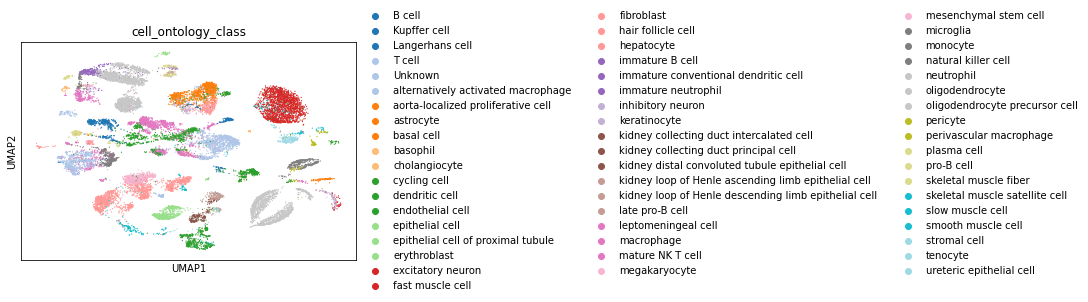

In [ ]:
sc.pl.umap(
    target_adata,
    color='cell_ontology_class',
    palette='tab20',
)

In [ ]:
target_adata = match_colors(
    adata=target_adata,
    source_cat='cell_ontology_class',
    target_cat='scNym',
)

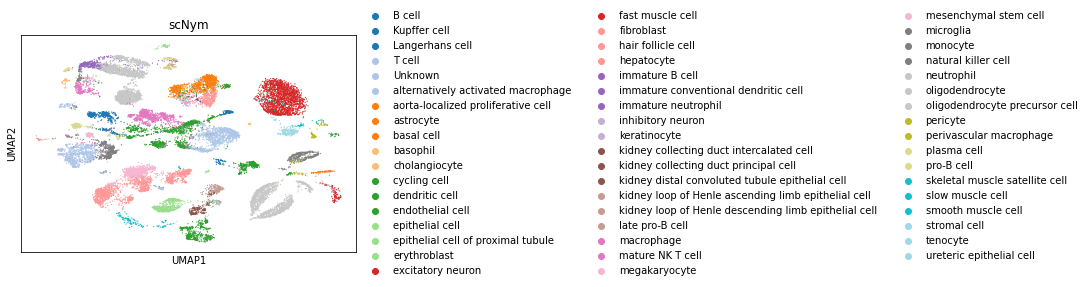

In [ ]:
sc.pl.umap(
    target_adata,
    color='scNym',
)

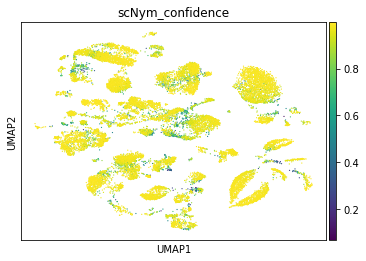

In [ ]:
sc.pl.umap(
  target_adata,
  color='scNym_confidence',
)

## Plot model embeddings

`scnym_api` also extracts the activations of the penultimate neural network layer. These activations represent the embedding learned by the scNym model.

In [ ]:
sc.pp.neighbors(adata, use_rep='X_scnym', n_neighbors=30)

In [ ]:
sc.tl.umap(adata, min_dist=0.3)

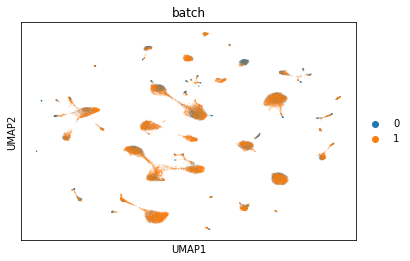

In [ ]:
sc.pl.umap(adata, color='batch', size=5., alpha=0.2)

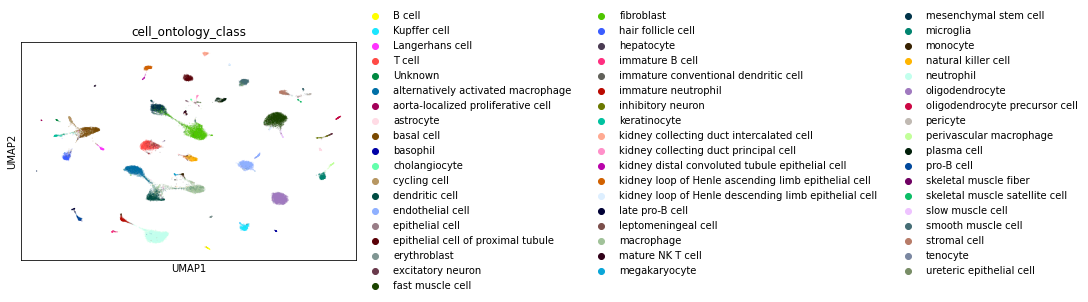

In [ ]:
sc.pl.umap(adata, color='cell_ontology_class', size=5., alpha=0.2)

## Save scNym annotations to locally or to gDrive

In [ ]:
target_adata.obs.to_csv(
    './annotations.csv'
)

In [ ]:
# save files locally
from google.colab import files

files.download('annotations.csv')

In [ ]:
# save files to Google Drive
from google.colab import drive
drive.mount('/gdrive')

# make a directory if not present already
!mkdir "/gdrive/My Drive/scnym/"
# copy file to gDrive
!cp annotations.csv "/gdrive/My Drive/scnym/annotations.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
mkdir: cannot create directory ‘/gdrive/My\\ Drive/scnym/’: No such file or directory
cp: cannot create regular file '/gdrive/My\ Drive/scnym/annotations.csv': No such file or directory
